<a href="https://colab.research.google.com/github/peeyushaga/micrograd/blob/main/ngrad_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

In [30]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    # convert data into numpy array
    if isinstance(data, np.ndarray):
      self.data = data
    else:
      self.data = np.array(data)

    #initializing grad array
    self.grad = np.zeros_like(self.data)

    #placeholder for backward function
    self._backward = lambda:None

    #set of previous node
    self._prev = set(_children)

    #operation performed
    self._op = _op

    #label for node
    self.label = label



  def __add__(self, other):
    # Convert other to a Value if it is not already
    other = other if isinstance(other, Value) else Value(other)

    # Create a new Value instance representing the addition operation
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      # Calculate the gradients using the chain rule and update the gradients of the operands
      self.grad = self.grad + (1.0 * out.grad)
      other.grad = other.grad + (1.0 * out.grad)

    # Assign the backward function to the new Value instance
    out._backward = _backward
    return out

  def __mul__(self, other):
    #converting other to Value
    other = other if isinstance(other, Value) else Value(other)
    #output of the operation
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      #calculating the gradients using chain rule
      self.grad += other.data*out.grad
      other.grad += self.data*out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    #other is scalar
    if isinstance(other, (int, float)):
      out = Value(np.power(self.data, other), (self, ), f'**')

      def _backward():
        #calculating the gradients using chain rule
        self.grad += other * np.power(self.data, other-1) * out.grad
      out._bakcward = _backward
      return out

    elif isinstance(other, Value):
      out = Value(np.power(self.data, other.data), (self, other), f'**{other.data}')

      def _backward():
        self.grad += other.data * np.power(self.data, other.data - 1) * out.grad
        other.grad += np.power(self.data, other.data)*np.log(self.data)*out.grad
      out._baclward = _backward
      return out

    else:
      raise TypeError("Unsupported operand type(s) for **: 'Value' and '{}'".format(type(other).__name__))


  def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out

  def exp(self):
    x = self.data
    out = Value(np.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = np.tanh(x)
    out = Value(t, (self,),'tanh')

    def _backward():
      self.grad += (1 - t**2)*out.grad
    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other

  def __rmul__(self, other):
    return self*other

  def __truediv__(self, other):
    return self*(other**-1)

  def __neg__(self):
    return self*-1

  def __sub__(self, other):
    return self + (-other)

  def backward(self):
    #perform backprogation
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = np.ones_like(self.data)

    for node in reversed(topo):
      node._backward()

  def __repr__(self):
    return f"Value(data={self.data})"

In [3]:
from graphviz import Digraph

def trace(root):
    # Initialize empty sets for nodes and edges
    nodes, edges = set(), set()

    # Recursive function to build the set of nodes and edges
    def build(v):
        # If the current node is not in the set of nodes
        if v not in nodes:
            # Add the current node to the set of nodes
            nodes.add(v)

            # Iterate over the previous nodes (parents) of the current node
            for child in v._prev:
                # Add an edge from the previous node to the current node
                edges.add((child, v))

                # Recursively call build() on the previous node
                build(child)

    # Start building the set of nodes and edges from the root node
    build(root)

    # Return the set of nodes and edges
    return nodes, edges


def draw_dot(root):
    # Create a Digraph object with SVG format and set the graph attribute 'rankdir' to 'LR'
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    # Retrieve the nodes and edges from the root
    nodes, edges = trace(root)

    # Iterate over the nodes
    for n in nodes:
        uid = str(id(n))
        # Convert the data array to a string representation
        data_str = np.array2string(n.data, precision=4, separator=',', suppress_small=True)
        # Convert the gradient array to a string representation
        grad_str = np.array2string(n.grad, precision=4, separator=',', suppress_small=True)
        # Create the label for the node using the node's label, data, and gradient strings
        label = "{ %s | data %s | grad %s }" % (n.label, data_str, grad_str)
        # Add a node to the graph with a unique ID, label, and shape 'record'
        dot.node(name=uid, label=label, shape='record')

        # If the node has an operation associated with it
        if n._op:
            # Add a node to the graph with a unique ID based on the node's ID and operation, and label it with the operation
            dot.node(name=uid + n._op, label=n._op)
            # Add an edge from the operation node to the current node
            dot.edge(uid + n._op, uid)

    # Iterate over the edges
    for n1, n2 in edges:
        # Add an edge from the first node's ID to the second node's ID concatenated with the operation name
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    # Return the generated graph
    return dot

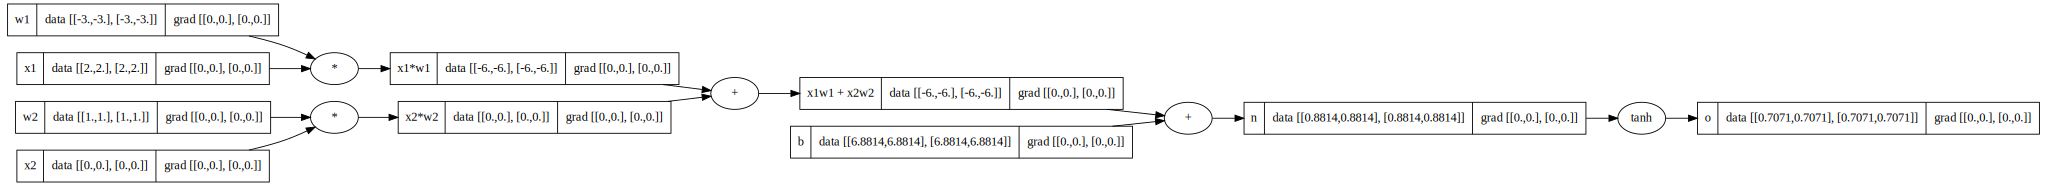

In [4]:
# constructing and visualizing the computation graph for a simple neural network forward pass

# inputs x1, x2
x1 = Value([[2.0, 2.0], [2.0, 2.0]], label="x1")
x2 = Value([[0.0, 0.0], [0.0, 0.0]], label="x2")

# weights w1, w2
w1 = Value([[-3.0, -3.0], [-3.0, -3.0]], label="w1")
w2 = Value([[1.0, 1.0], [1.0, 1.0]], label="w2")

# bias of the neurons
b = Value([[6.8813735870195432, 6.8813735870195432], [6.8813735870195432, 6.8813735870195432]], label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# apply the hyperbolic tangent function to n
o = n.tanh(); o.label = 'o'

# visualize the computation graph
draw_dot(o)

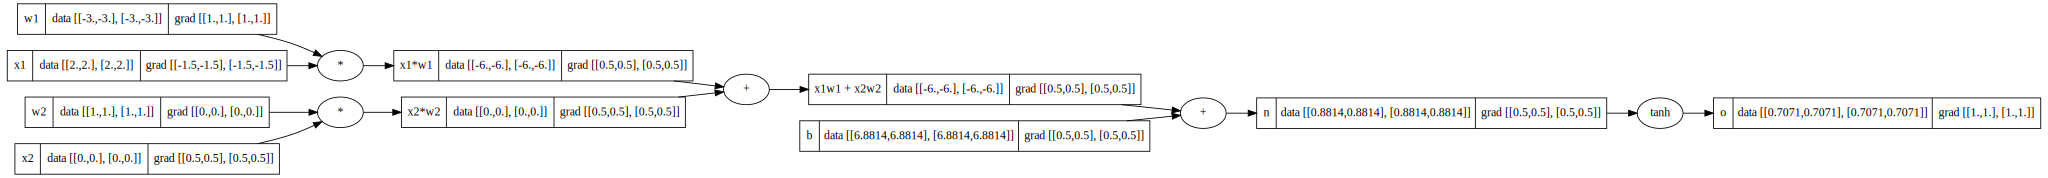

In [5]:
# perform backward propagation to compute gradients
o.backward()

# visualizing the updated computation graph
draw_dot(o)

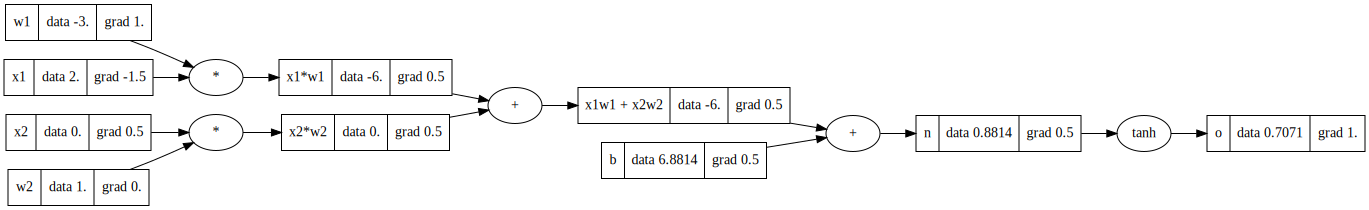

In [10]:
# constructing and visualizing the computation graph for a neural network forward pass and performing backward propagation

# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neurons
b = Value(6.8813735870195432, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# break tanh() into the following expression (hyperbolic tangent)

# computes the value of 'e' by taking the exponential function of the expression '2*n'
e = np.exp(2.0*n); e.label = 'e'
# computes the value of 'o' using the values of 'e' & subtracts 1 from 'e' and divides it by 'e' plus 1, following a mathematical expression

#o = (e - 1.0) / (e + 1.0); o.label = 'o'
o = n.tanh(); o.label = 'o'

# perform backward propagation to compute gradients
o.backward()

# visualizing the updated computation graph
draw_dot(o)

In [9]:
import torch

#create tensors and enable gradient tracking

#inputs x1, x2
x1 = torch.Tensor([2.0]); x1.requires_grad = True
x2 = torch.Tensor([-.0]); x2.requires_grad = True

#weights w1, w2
w1 = torch.Tensor([-3.0]); w1.requires_grad = True
w2 = torch.Tensor([1.0]); w2.requires_grad = True

#bias of neurons
b = torch.Tensor([6.8813735870195432]); b.requires_grad = True

#perform computation
n = x1*w1 + x2*w2 + b

#apply tanh function
o = torch.tanh(n)

#perfroming backprogation
o.backward()

print("------------")
print("x1", x1.grad.item())
print("w1", w1.grad.item())
print("x2", x2.grad.item())
print("w2", w2.grad.item())

------------
x1 -1.5000003576278687
w1 1.000000238418579
x2 0.5000001192092896
w2 -0.0


In [31]:
import random

class Neuron:

  def __init__(self, nin):
    #initialize neron with random weights and bias
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    #calculate wi*xi + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    #apply tanh
    out = act.tanh()

    return out

  def parameters(self):
    #return weigts and bias
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    #create a layer(list) of 'nout' neurons with specified inputs
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    #compute output for each neuron
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    #return paramets of all neurons in the layer
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    #create a multi-layered perceptron with specified number of inputs and outputs for each neuron
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    #foward propogation
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [32]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [33]:
n = MLP(3, [4,4,1])

In [34]:
for k in range(20):

  #foward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2.0 for ygt, yout in zip(ys, ypred))

  #backpass
  for p in n.parameters():
    p.grad = 0.0

  #compute the gradients
  loss.backward()

  # Update weights
  for p in n.parameters():
      p.data += -0.5 * p.grad

  print(k, loss.data)

0 5.249968603062127
1 5.249968603062127
2 5.249968603062127
3 5.249968603062127
4 5.249968603062127
5 5.249968603062127
6 5.249968603062127
7 5.249968603062127
8 5.249968603062127
9 5.249968603062127
10 5.249968603062127
11 5.249968603062127
12 5.249968603062127
13 5.249968603062127
14 5.249968603062127
15 5.249968603062127
16 5.249968603062127
17 5.249968603062127
18 5.249968603062127
19 5.249968603062127
